# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [19]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util

In [20]:
today = datetime.datetime.now() #date.today()
tomorrow = today + datetime.timedelta(days = 1)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [21]:
project = hopsworks.login()
conn = hopsworks.connection()
fs = project.get_feature_store() 

location_str = conn.get_secrets_api().get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']
print(location_str)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works/p/5240
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.
{"country": "sweden", "city": "stockholm", "street": "stockholm-hornsgatan-108-gata"}


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [ ]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.5450603E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using ArrowFlight (0.47s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-03-24 00:00:00+00:00,2.70,0.2,11.269782,63.435013,stockholm
1,2024-03-25 00:00:00+00:00,2.90,0.0,6.877790,83.991089,stockholm
2,2024-03-27 00:00:00+00:00,1.25,0.0,11.367109,349.045959,stockholm
3,2024-03-26 00:00:00+00:00,1.60,0.6,11.440979,114.145538,stockholm
4,2024-03-28 00:00:00+00:00,1.60,0.0,15.141414,71.995750,stockholm
5,2024-03-29 00:00:00+00:00,1.40,0.4,7.636753,351.869995,stockholm
6,2024-03-30 00:00:00+00:00,5.20,0.2,20.696087,139.939285,stockholm
7,2024-03-31 00:00:00+00:00,15.05,0.0,13.246826,222.797379,stockholm
8,2024-04-01 00:00:00+00:00,16.75,0.0,10.086427,182.045364,stockholm


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-03-24 00:00:00+00:00,2.70,0.2,11.269782,63.435013,stockholm,34.185936
1,2024-03-25 00:00:00+00:00,2.90,0.0,6.877790,83.991089,stockholm,46.524021
2,2024-03-27 00:00:00+00:00,1.25,0.0,11.367109,349.045959,stockholm,21.637419
3,2024-03-26 00:00:00+00:00,1.60,0.6,11.440979,114.145538,stockholm,43.967888
4,2024-03-28 00:00:00+00:00,1.60,0.0,15.141414,71.995750,stockholm,24.703060
5,2024-03-29 00:00:00+00:00,1.40,0.4,7.636753,351.869995,stockholm,13.098204
6,2024-03-30 00:00:00+00:00,5.20,0.2,20.696087,139.939285,stockholm,42.301991
7,2024-03-31 00:00:00+00:00,15.05,0.0,13.246826,222.797379,stockholm,24.030804
8,2024-04-01 00:00:00+00:00,16.75,0.0,10.086427,182.045364,stockholm,24.858345


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 452.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-03-24 00:00:00+00:00,2.70,0.2,11.269782,63.435013,stockholm,34.185936,stockholm-hornsgatan-108-gata,sweden,1
1,2024-03-25 00:00:00+00:00,2.90,0.0,6.877790,83.991089,stockholm,46.524021,stockholm-hornsgatan-108-gata,sweden,2
3,2024-03-26 00:00:00+00:00,1.60,0.6,11.440979,114.145538,stockholm,43.967888,stockholm-hornsgatan-108-gata,sweden,4
2,2024-03-27 00:00:00+00:00,1.25,0.0,11.367109,349.045959,stockholm,21.637419,stockholm-hornsgatan-108-gata,sweden,3
4,2024-03-28 00:00:00+00:00,1.60,0.0,15.141414,71.995750,stockholm,24.703060,stockholm-hornsgatan-108-gata,sweden,5
5,2024-03-29 00:00:00+00:00,1.40,0.4,7.636753,351.869995,stockholm,13.098204,stockholm-hornsgatan-108-gata,sweden,6
6,2024-03-30 00:00:00+00:00,5.20,0.2,20.696087,139.939285,stockholm,42.301991,stockholm-hornsgatan-108-gata,sweden,7
7,2024-03-31 00:00:00+00:00,15.05,0.0,13.246826,222.797379,stockholm,24.030804,stockholm-hornsgatan-108-gata,sweden,8
8,2024-04-01 00:00:00+00:00,16.75,0.0,10.086427,182.045364,stockholm,24.858345,stockholm-hornsgatan-108-gata,sweden,9


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

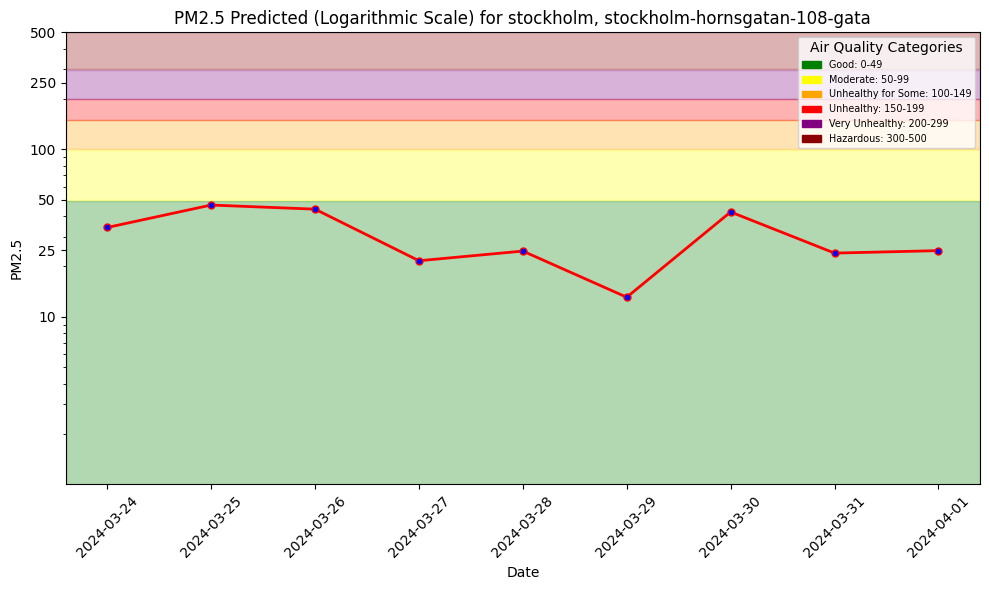

In [12]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_monitoring',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['country','street','date', 'days_before_forecast_day'],
    event_time="date"
)

In [14]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_monitoring_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://snurran.hops.works/p/5240/jobs/named/aq_monitoring_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7efb3057f0a0>, None)

In [15]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using ArrowFlight (0.50s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-03-09 00:00:00+00:00,0.70,0.0,10.495713,59.036320,stockholm,35.458157,stockholm-hornsgatan-108-gata,sweden,1
1,2024-03-10 00:00:00+00:00,0.50,0.0,15.790833,114.227737,stockholm,36.469070,stockholm-hornsgatan-108-gata,sweden,1
2,2024-03-11 00:00:00+00:00,3.50,0.0,12.224107,103.627014,stockholm,38.769756,stockholm-hornsgatan-108-gata,sweden,1
3,2024-03-12 00:00:00+00:00,5.40,0.0,7.903619,120.068497,stockholm,54.161850,stockholm-hornsgatan-108-gata,sweden,1
4,2024-03-13 00:00:00+00:00,3.40,0.0,9.793058,197.102814,stockholm,32.752457,stockholm-hornsgatan-108-gata,sweden,1
5,2024-03-16 00:00:00+00:00,8.80,0.1,11.525623,181.789871,stockholm,41.385178,stockholm-hornsgatan-108-gata,sweden,1
6,2024-03-19 00:00:00+00:00,3.80,0.0,1.835647,191.309891,stockholm,47.807198,stockholm-hornsgatan-108-gata,sweden,1
7,2024-03-20 00:00:00+00:00,2.85,0.1,9.178235,191.309891,stockholm,45.177952,stockholm-hornsgatan-108-gata,sweden,1
8,2024-03-21 00:00:00+00:00,4.50,0.1,6.369050,312.709381,stockholm,34.422592,stockholm-hornsgatan-108-gata,sweden,1
9,2024-03-22 00:00:00+00:00,5.40,0.0,14.812590,205.942245,stockholm,36.072220,stockholm-hornsgatan-108-gata,sweden,1


In [16]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using ArrowFlight (0.45s) 


,date,pm25,country,city,street
0,2017-10-18 00:00:00+00:00,10.0,sweden,stockholm,stockholm-hornsgatan-108-gata
1,2020-06-17 00:00:00+00:00,30.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2,2023-04-12 00:00:00+00:00,62.0,sweden,stockholm,stockholm-hornsgatan-108-gata
3,2020-03-22 00:00:00+00:00,16.0,sweden,stockholm,stockholm-hornsgatan-108-gata
4,2018-11-11 00:00:00+00:00,57.0,sweden,stockholm,stockholm-hornsgatan-108-gata
...,...,...,...,...,...
2281,2024-03-19 00:00:00+00:00,17.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2282,2024-03-20 00:00:00+00:00,17.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2283,2024-03-21 00:00:00+00:00,41.0,sweden,stockholm,stockholm-hornsgatan-108-gata
2284,2024-03-22 00:00:00+00:00,14.0,sweden,stockholm,stockholm-hornsgatan-108-gata


In [17]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

,date,predicted_pm25,pm25
0,2024-03-09 00:00:00+00:00,35.458157,35.0
1,2024-03-10 00:00:00+00:00,36.469070,24.0
2,2024-03-11 00:00:00+00:00,38.769756,26.0
3,2024-03-12 00:00:00+00:00,54.161850,46.0
4,2024-03-13 00:00:00+00:00,32.752457,51.0
5,2024-03-16 00:00:00+00:00,41.385178,45.0
6,2024-03-19 00:00:00+00:00,47.807198,17.0
7,2024-03-20 00:00:00+00:00,45.177952,17.0
8,2024-03-21 00:00:00+00:00,34.422592,41.0
9,2024-03-22 00:00:00+00:00,36.072220,14.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

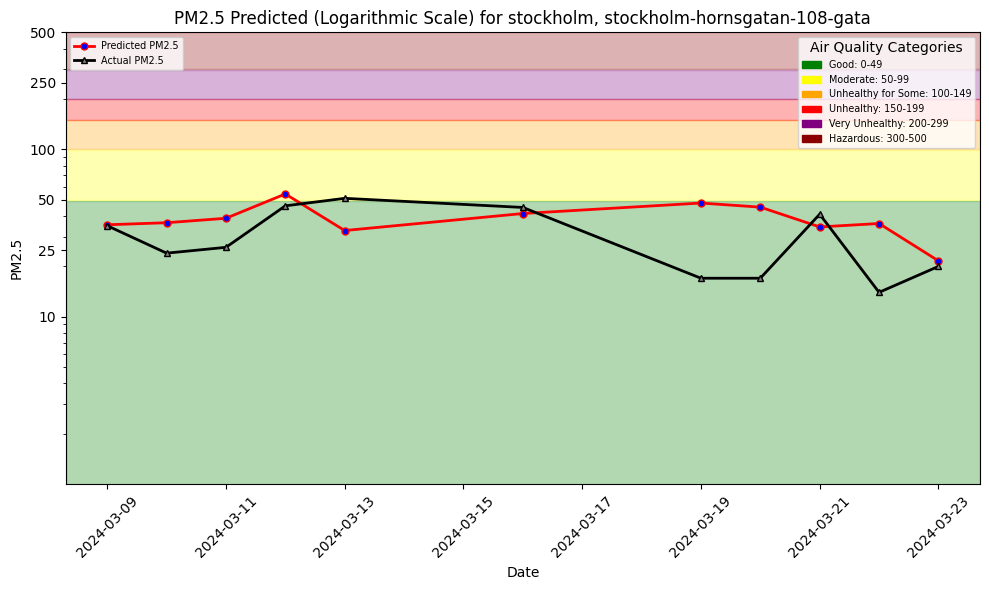

In [18]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---